# Exploratory Data Analysis

On this notebook, an exploratory data analysis will be performed over the cleaned data.

## Importing dependencies

In [1]:
import pandas as pd # To handle data
import seaborn as sns # To visualize data
# To prettify pandas dataframes prints
pd.set_option('expand_frame_repr', False)

## Loading data

In [2]:
# Loading clean video games and platforms datasets
games_df = pd.read_csv('./cleaned_data/games.zip')
platforms_df = pd.read_csv('./cleaned_data/platforms.zip')

## EDA

### Platforms dataframe

#### Dataframe glimpse

In [3]:
print(platforms_df.head())
print('...')
print(platforms_df.tail())

    id        platform          version  category  generation platform_family         region release_date
0  158  Commodore CDTV  Initial version  computer         4.0             NaN  north_america   1991-03-03
1  158  Commodore CDTV  Initial version  computer         4.0             NaN         europe   1991-11-14
2  158  Commodore CDTV  Initial version  computer         4.0             NaN      australia   1991-07-12
3    8   PlayStation 2  Initial version   console         6.0     PlayStation          japan   2000-03-04
4    8   PlayStation 2  Initial version   console         6.0     PlayStation  north_america   2000-10-26
...
     id         platform          version category  generation platform_family         region release_date
378   7      PlayStation    PlayStation 1  console         5.0     PlayStation          japan   1994-12-03
379   7      PlayStation    PlayStation 1  console         5.0     PlayStation  north_america   1995-09-09
380   7      PlayStation    PlayStation

In [4]:
platforms_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               383 non-null    int64  
 1   platform         383 non-null    object 
 2   version          383 non-null    object 
 3   category         374 non-null    object 
 4   generation       345 non-null    float64
 5   platform_family  200 non-null    object 
 6   region           325 non-null    object 
 7   release_date     325 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 24.1+ KB


We need to adjust `release_date` column to convert its values to datetimes and `generation` column to be treated as integers.

In [5]:
platforms_df = platforms_df.astype(
    {'generation':'Int64', 
     'release_date':'datetime64'
    }
)
platforms_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               383 non-null    int64         
 1   platform         383 non-null    object        
 2   version          383 non-null    object        
 3   category         374 non-null    object        
 4   generation       345 non-null    Int64         
 5   platform_family  200 non-null    object        
 6   region           325 non-null    object        
 7   release_date     325 non-null    datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), int64(1), object(5)
memory usage: 24.4+ KB


Now, we will take a look to the missing values

In [6]:
print('Number of missing values per column\n')
n_rows = len(platforms_df)
print(f'Total rows = {len(platforms_df)}\n')

for c in platforms_df.columns:
    n_nans = platforms_df[c].isna().sum()
    print(f'{c} ({platforms_df[c].dtype}): {n_nans} = {(n_nans/n_rows)*100}%')

Number of missing values per column

Total rows = 383

id (int64): 0 = 0.0%
platform (object): 0 = 0.0%
version (object): 0 = 0.0%
category (object): 9 = 2.3498694516971277%
generation (Int64): 38 = 9.921671018276761%
platform_family (object): 183 = 47.78067885117493%
region (object): 58 = 15.143603133159269%
release_date (datetime64[ns]): 58 = 15.143603133159269%


As we discussed in the [data cleaning notebook](https://github.com/Pedro-Hdez/feature-engeneering-process/blob/main/2_data_cleaning.ipynb), missing values on this dataframe are not of major importance since it is an auxiliar dataframe.

#### Counting frequencies

##### Number of unique values per column

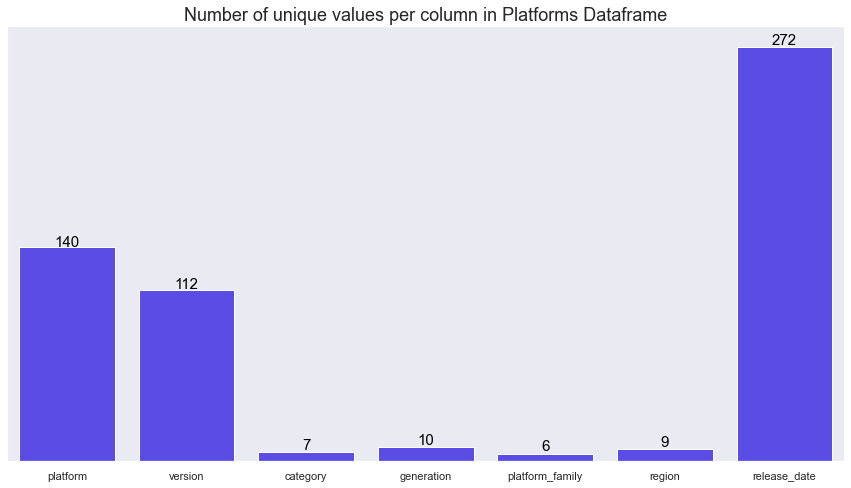

In [7]:
# Set figure size and background
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("dark")

# Getting number of unique values per column
nu = platforms_df.iloc[:,1:].nunique().reset_index()
nu.columns = ['feature','nunique']

# Plotting unique values in a barplot
ax = sns.barplot(
    x='feature', 
    y='nunique', 
    data=nu,
    color=(70/255, 51/255, 255/255, 0.8)
)

ax.set_title(
    "Number of unique values per column in Platforms Dataframe", 
    fontsize = 18)
ax.set_xlabel("", fontsize = 15)
ax.set_ylabel("", fontsize = 15)
ax.axes.yaxis.set_ticklabels([])

# Adding the bars actual value
i = 0
for c in platforms_df.columns[1:]:
    value = len(platforms_df[c].unique())
    ax.text(i,value+1, int(value), color='black', ha="center", fontsize=15)
    i += 1

Recall the dataframe is tidy, which means every row is a unique observation. Since a platform could have multiple versions and regions, a lot of rows will have their `platform` value repeated. For this reason we need to obtain a new dataframe containing only unique platforms.

In [8]:
# Sort the original dataframe by release date because we will group and then
# take the first item of each group, so this first element will be the
# observation related to the first time the platform was released.
platforms_df = platforms_df.sort_values('release_date', ascending=True)
# Getting unique platforms
unique_platforms = platforms_df.groupby("platform").first().reset_index()
# Getting release year of the platforms
unique_platforms['release_year'] = unique_platforms.release_date.dt.year
# Getting release month of the platforms
unique_platforms['release_month'] = unique_platforms.release_date.dt.month

The procedure to make a count plot regardless of the column is always the same, for this reason the following function was built.

In [9]:
def plotCount(df, plot_size, column, title, xlabel, ylabel, col, ordr,
              value_offset, rotate_xticks=False):
    '''
        This function makes a count plot using the dataframe "unique_platforms"
        which contains all the platforms with no repetitons.
        
        Params
        ------
        df <pandas.DataFrame>: Dataframe where data is
        plot_size <tuple>: tuple with desired with and height of the plot
        column <str>: Column where frequencies will be obtained
        title <str>: Plot title
        xlabel <str>: X axis label
        ylabel <str>: Y axis label
        col <tuple>: Normalized rgba color 
        ordr <list>: List with the categories order to display
        value_offset <float>: Distance from the bar to its value
        rotate_xticks <bool>: Whether or not to rotate the x axis labels
    '''
    
    # Setting plot size and background
    sns.set(rc = {'figure.figsize':plot_size})
    sns.set_style("dark")
    
    # Building the countplot
    countplot = sns.countplot(
        data = df,
        x=column,
        color=col,
        order = ordr
    )
    countplot.set_title(title, fontsize = 18)
    countplot.set_xlabel(xlabel, fontsize = 15)
    countplot.set_ylabel(ylabel, fontsize = 15)
    countplot.axes.yaxis.set_ticklabels([])
    
    # Rotate x labels if necessary
    if rotate_xticks:
        for item in countplot.get_xticklabels():
            item.set_rotation(45)
    
    # Adding the actual value to the bars
    i = 0
    for c in ordr:
        value = len(df[df[column] == c])
        countplot.text(i,value+value_offset, int(value), color='black', 
                       ha="center", fontsize=15
                      )
        i += 1

##### Category count

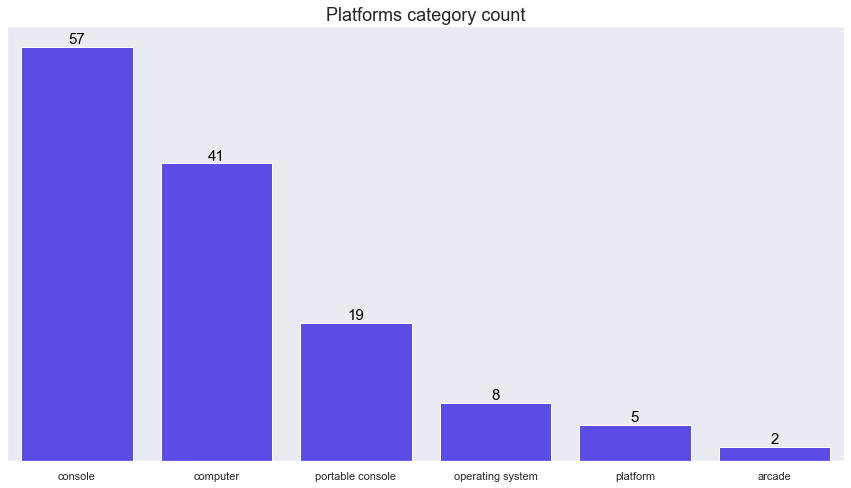

In [10]:
column = 'category'
title = 'Platforms category count'
xlabel = ''
ylabel = ''
plot_size = (15,8)
color_platforms = (70/255, 51/255, 255/255, 0.8)
ordr = unique_platforms[column].value_counts().index
value_offset = .5
plotCount(unique_platforms, plot_size, column, title, xlabel, ylabel, 
          color_platforms, ordr, value_offset
         )

We can see `console` is the most populated category because up to the present day the most common way to play video games is through a console like Nintendo Wii, Playstation 4 or Xbox One. 

The second place goes to `computer` category and this is a particularly interesting discovery because majority of people doesn't know so many computer models, but an even more interesting fact is the release dates of this computers as we can see below: 

##### *Computer* category release years

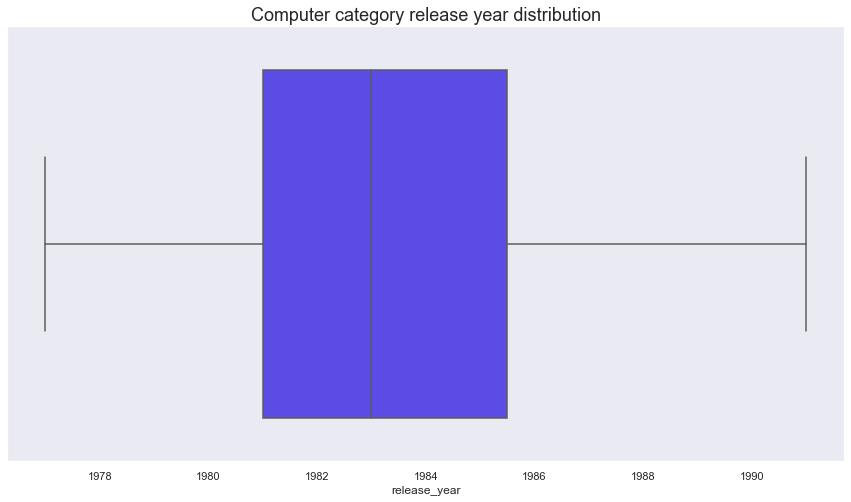

In [11]:
boxplot = sns.boxplot(
    x=unique_platforms[unique_platforms.category == 'computer'].release_year, 
    color=color_platforms
)

_ = boxplot.set_title(
    'Computer category release year distribution', 
    fontsize = 18)

The models of the computers platforms are fairly old!

##### Generation count

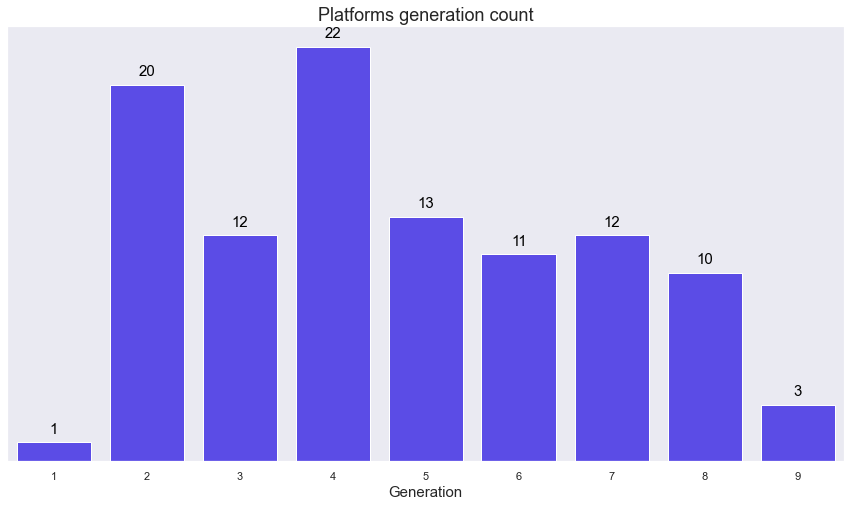

In [12]:
column = 'generation'
title = 'Platforms generation count'
xlabel = 'Generation'
ylabel = ''
ordr = [i for i in range (1,10)]
plotCount(unique_platforms, plot_size, column, title, xlabel, ylabel, 
          color_platforms, ordr, value_offset)

Fourth generation (1987-1993) is the most populated in terms of released consoles. This is because in those years the video games industry was young, fertile, and it was growing rapidly, then so many companies wanted to be part of it. 

##### Family count

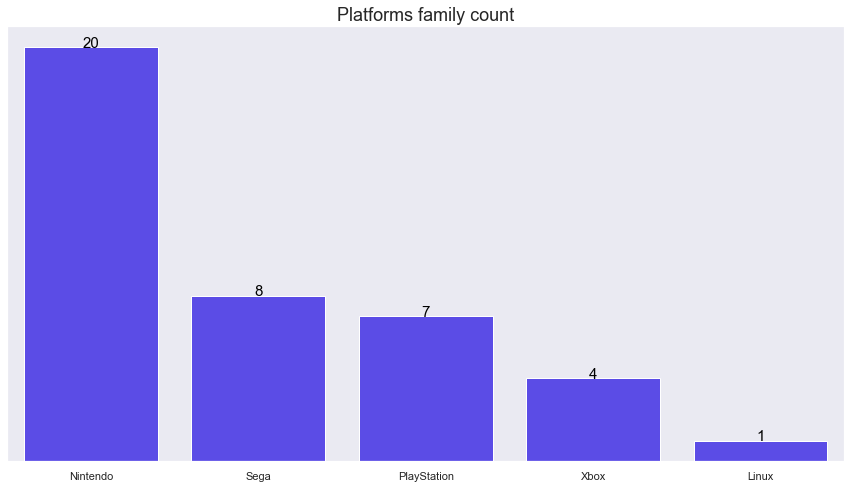

In [13]:
column = 'platform_family'
title = 'Platforms family count'
xlabel = ''
ylabel = ''
ordr = unique_platforms[column].value_counts().index
value_offset = 0
plotCount(unique_platforms, plot_size, column, title, xlabel, ylabel, 
          color_platforms, ordr, value_offset)

We can see  **Nintendo** as the family with more platforms. Because since ever this company is one of the strongest rivals to beat up.

##### Release years

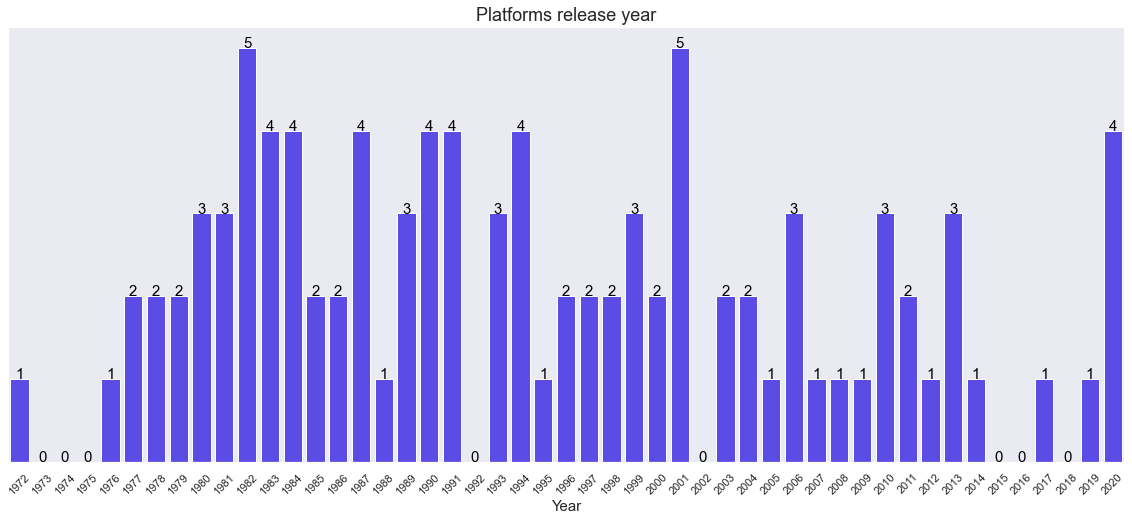

In [14]:
column = 'release_year'
title = 'Platforms release year'
xlabel = 'Year'
ylabel = ''
plot_size = (20,8)
rotate_xticks = True
ordr = [i for i in range(int(unique_platforms.release_year.min()), 
                         int(unique_platforms.release_year.max())+1)]
plotCount(unique_platforms, plot_size, column, title, xlabel, ylabel, 
          color_platforms, ordr, value_offset, rotate_xticks)

We can see platforms releases has been relatively uniform across the years.

##### Release months

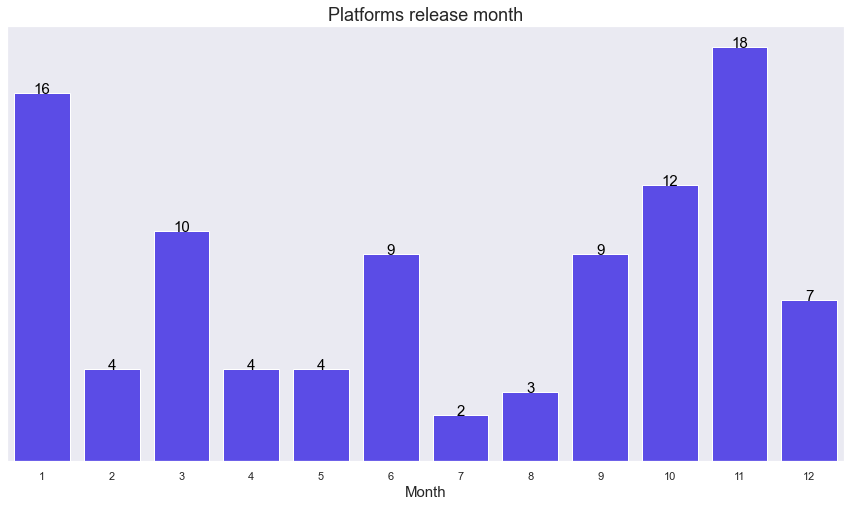

In [15]:
column = 'release_month'
title = 'Platforms release month'
xlabel = 'Month'
ylabel = ''
plot_size = (15,8)
ordr = [i for i in range(1,13)]
plotCount(unique_platforms, plot_size, column, title, xlabel, ylabel, 
          color_platforms, ordr, value_offset)

This plot is very interesting and we can see a business strategy here. Note that the majority of consoles has been released in november, but we can see the increase begins in september. This is so that the customers have time to know the platforms and buy them at Christmas. 

### Video games dataframe

#### Dataframe glimpse

In [16]:
print(games_df.head())
print('...')
print(games_df.tail())

     id          name                platform release_date              genre   category     game_modes  total_rating
0  2603  Battle Chess  PC (Microsoft Windows)   1988-10-01           Strategy  main_game  Single player      71.97295
1  2603  Battle Chess  PC (Microsoft Windows)   1988-10-01           Strategy  main_game    Multiplayer      71.97295
2  2603  Battle Chess  PC (Microsoft Windows)   1988-10-01  Card & Board Game  main_game  Single player      71.97295
3  2603  Battle Chess  PC (Microsoft Windows)   1988-10-01  Card & Board Game  main_game    Multiplayer      71.97295
4  2603  Battle Chess                  PC DOS   1988-10-01           Strategy  main_game  Single player      71.97295
...
           id                             name         platform release_date                       genre   category     game_modes  total_rating
269309   9426                       Sweet Home  Family Computer   1989-12-15                   Adventure  main_game  Single player     60.14177

In [17]:
games_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269314 entries, 0 to 269313
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            269314 non-null  int64  
 1   name          269314 non-null  object 
 2   platform      269314 non-null  object 
 3   release_date  269244 non-null  object 
 4   genre         267810 non-null  object 
 5   category      269314 non-null  object 
 6   game_modes    262761 non-null  object 
 7   total_rating  269314 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 16.4+ MB


We need to adjust `release_date` column to convert its values to datetimes.

In [18]:
games_df = games_df.astype({'release_date':'datetime64'})
games_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269314 entries, 0 to 269313
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            269314 non-null  int64         
 1   name          269314 non-null  object        
 2   platform      269314 non-null  object        
 3   release_date  269244 non-null  datetime64[ns]
 4   genre         267810 non-null  object        
 5   category      269314 non-null  object        
 6   game_modes    262761 non-null  object        
 7   total_rating  269314 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 16.4+ MB


Now, we will take a look to the missing values

In [19]:
print('Number of missing values per column\n')
n_rows = len(games_df)
print(f'Total rows = {len(games_df)}\n')

for c in games_df.columns:
    n_nans = games_df[c].isna().sum()
    print(f'{c} ({games_df[c].dtype}): {n_nans} = {(n_nans/n_rows)*100}%')

Number of missing values per column

Total rows = 269314

id (int64): 0 = 0.0%
name (object): 0 = 0.0%
platform (object): 0 = 0.0%
release_date (datetime64[ns]): 70 = 0.02599196476974832%
genre (object): 1504 = 0.558455928767164%
category (object): 0 = 0.0%
game_modes (object): 6553 = 2.433219216230868%
total_rating (float64): 0 = 0.0%


As we discussed in the [data cleaning notebook](https://github.com/Pedro-Hdez/feature-engeneering-process/blob/main/2_data_cleaning.ipynb), missing values on this dataframe are not of major importance since we have a very small percentage of them, at the end of the day the most important column is `total_rating` which have not Nans.

#### Counting frequencies

##### Number of unique values per column

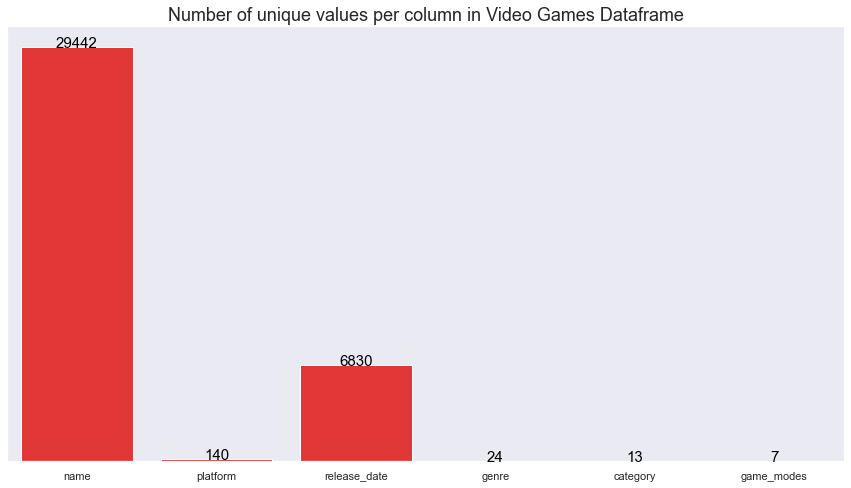

In [20]:
# Setting figure size and background
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("dark")
# Color to represent games plots
color_games = (255/255, 26/255, 26/255, 0.76)

# Getting number os unique values per column
nu = games_df.iloc[:,1:-1].nunique().reset_index()
nu.columns = ['feature','nunique']

# Plotting the unique values in a barplot
ax = sns.barplot(
    x='feature', 
    y='nunique', 
    data=nu,
    color=color_games
)

ax.set_title(
    "Number of unique values per column in Video Games Dataframe", 
    fontsize = 18
)
ax.set_xlabel("", fontsize = 15)
ax.set_ylabel("", fontsize = 15)
ax.axes.yaxis.set_ticklabels([])

# Adding the actual value to each bar
i = 0
for c in games_df.columns[1:-1]:
    value = len(games_df[c].unique())
    ax.text(i,value+1, int(value), color='black', ha="center", fontsize=15)
    i += 1

In [21]:
# Getting number of videogames per platform
games_per_platform = games_df.groupby(
    ['platform', 
     'name']
).size().groupby('platform').size()

# Getting platforms with most video games
platforms_most_games = games_per_platform.nlargest(10).to_frame().reset_index()
platforms_most_games.columns = ['platform', 'n_games']

# Getting platforms with less video games
platforms_less_games=games_per_platform.nsmallest(10).to_frame().reset_index()
platforms_less_games.columns = ['platform', 'n_games']

##### Top ten platforms with most video games

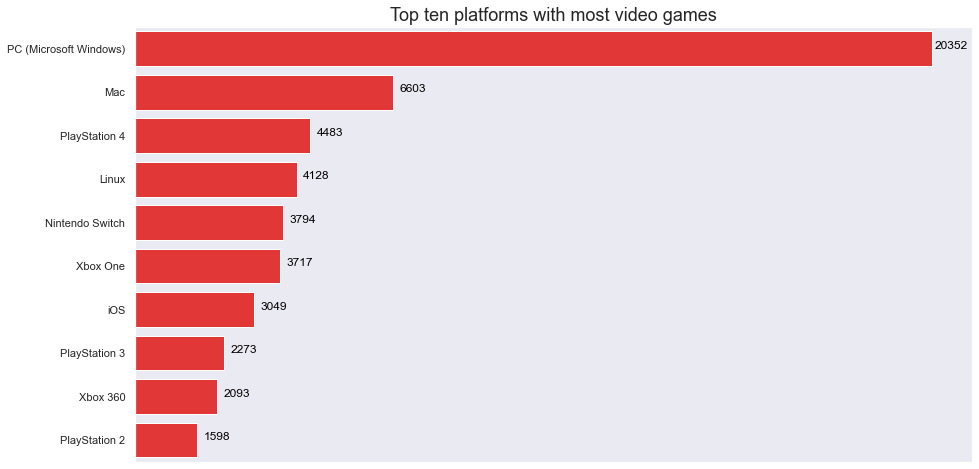

In [22]:
# Barplot
barplot = sns.barplot(
    data=platforms_most_games, 
    x='n_games',
    y='platform',
    color=color_games,
    orient = 'h'
)
barplot.set_title("Top ten platforms with most video games", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Adding actual value to each bar
for i in range(len(platforms_most_games)):
    value = platforms_most_games.iloc[i,1]
    barplot.text(value+500, i, int(value), color='black', ha="center")

It is impressive how Windows operating system has more than three times video games than the second place. Also, is very interesting that in the top ten we have four operating systems along six consoles!

##### Top ten platforms with less video games

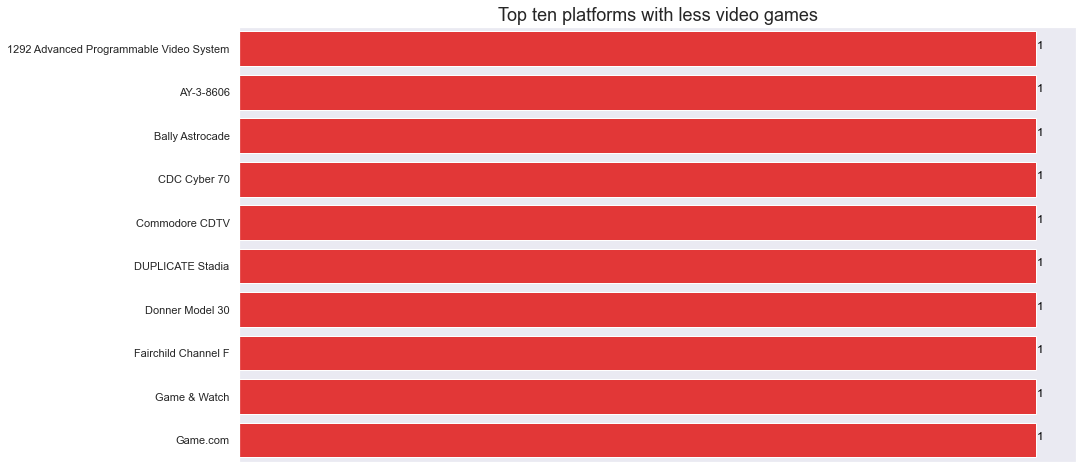

In [23]:
# Barplot
barplot = sns.barplot(
    data=platforms_less_games, 
    x='n_games',
    y='platform',
    color=color_games,
    orient = 'h'
)
barplot.set_title("Top ten platforms with less video games", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Adding actual value to each bar
for i in range(len(platforms_less_games)):
    value = platforms_less_games.iloc[i,1]
    barplot.text(value+.005, i, int(value), color='black', ha="center")

The top ten platforms with less video games only have one registered. If we check their release dates may encounter the reason of this

In [24]:
platforms_df[
    platforms_df.platform.isin(platforms_less_games.platform)
].groupby('platform').first()

,id,version,category,generation,platform_family,region,release_date
platform,,,,,,,
1292 Advanced Programmable Video System,139,Acetronic MPU-1000,console,2,None,worldwide,1979-01-01
AY-3-8606,147,Initial version,console,<NA>,None,None,NaT
Bally Astrocade,91,Initial version,console,2,None,None,NaT
CDC Cyber 70,109,Initial version,computer,<NA>,None,None,NaT
Commodore CDTV,158,Initial version,computer,4,None,north_america,1991-03-03
DUPLICATE Stadia,203,Initial version,None,<NA>,None,None,NaT
Donner Model 30,85,Initial version,computer,<NA>,None,None,NaT
Fairchild Channel F,127,Initial version,console,2,None,north_america,1976-11-01
Game & Watch,307,Initial version,portable console,2,Nintendo,worldwide,1980-04-28


As you can see, five of the ten are old. To be honest this consoles were not popular at all and is probable they have had very few games. Their age along their unpopularity explain why they have so few games registered.

Now, as we have seen, the most popular way to play video games (and the highest market) are the consoles. So it would be interesting to know which consoles have more and less games.

In [25]:
# Converting games per platform to a dataframe
games_per_platform_df = games_per_platform.to_frame().reset_index()
games_per_platform_df.columns = ['platform', 'n_games']

# Getting games per console
games_per_console = pd.merge(
    platforms_df[platforms_df.category == 'console'], 
    games_per_platform_df, 
    on='platform', 
    how = 'right'
)

In [26]:
# Getting unique console names
consoles_names_df = platforms_df[
    platforms_df.category == 'console'
].groupby('platform').size().to_frame().reset_index().iloc[:,0].to_frame()
# Merging console names and games per platform with an left join to get the 
# number of games per console
games_per_console = pd.merge(
    consoles_names_df, 
    games_per_platform_df, 
    on='platform', 
    how='left'
)

consoles_most_games = games_per_console.nlargest(10, 'n_games')
consoles_less_games = games_per_console.nsmallest(10, 'n_games')

##### Top ten consoles with most video games

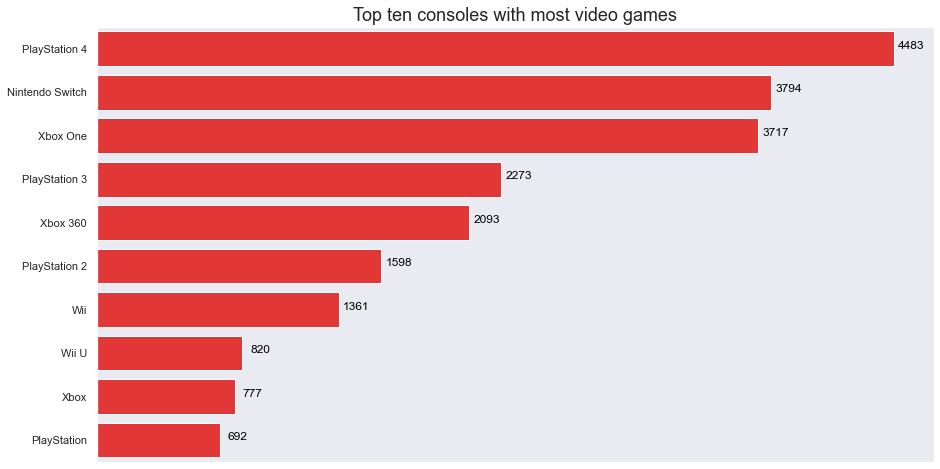

In [27]:
# Barplot
barplot = sns.barplot(
    data=consoles_most_games, 
    x='n_games',
    y='platform',
    color=color_games,
    orient = 'h'
)
barplot.set_title("Top ten consoles with most video games", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Adding actual value to each bar
for i in range(len(consoles_most_games)):
    value = consoles_most_games.iloc[i,1]
    barplot.text(value+100, i, int(value), color='black', ha="center")

We can see there is no place for another publisher but the three gigants of the industry: Nintendo, Playstation and Xbox.

##### Top ten consoles with less video games

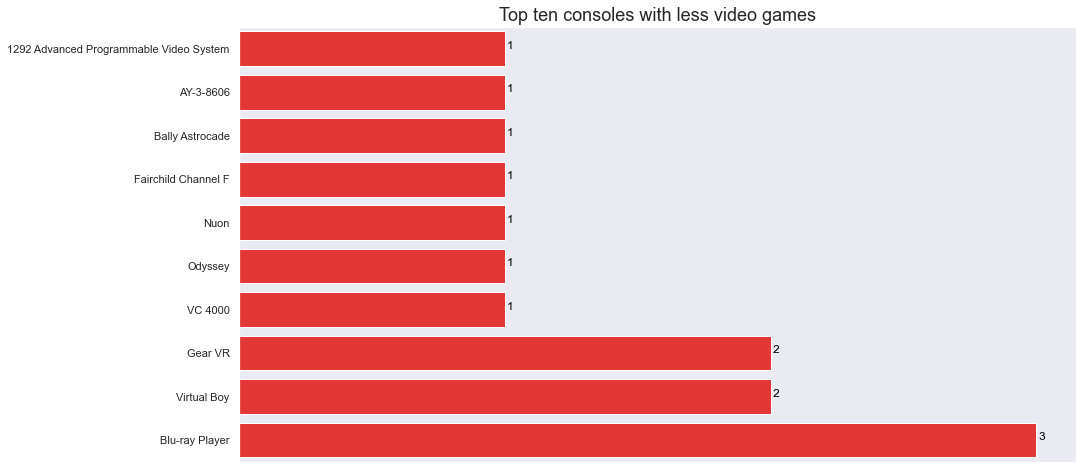

In [28]:
# Barplot
barplot = sns.barplot(
    data=consoles_less_games, 
    x='n_games',
    y='platform',
    color=color_games,
    orient = 'h'
)
barplot.set_title("Top ten consoles with less video games", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Adding actual value to each bar
for i in range(len(consoles_less_games)):
    value = consoles_less_games.iloc[i,1]
    barplot.text(value+.02, i, int(value), color='black', ha="center")

Again, the top ten consoles with less video games were not popular at all.

##### Genre count

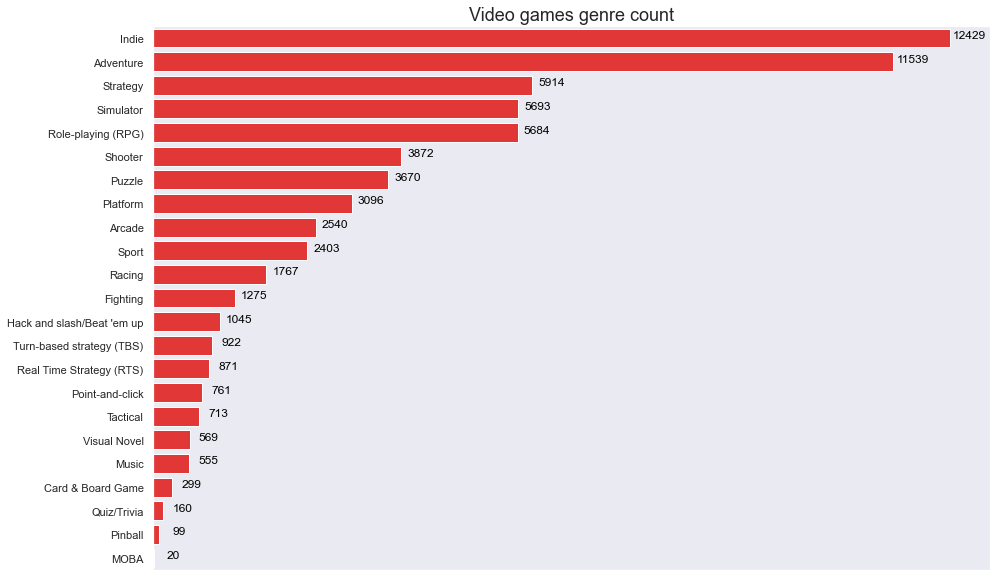

In [29]:
# Building a "higher" plot
sns.set(rc = {'figure.figsize':(15,10)})
sns.set_style("dark")

# Getting genres for each unique game
genre_df = games_df.groupby(
    ['name', 
     'genre']
).size().groupby(
    'genre'
).size().to_frame().reset_index().sort_values(0,ascending=False)

# Barplot
barplot = sns.barplot(
    data=genre_df, 
    x=0,
    y='genre',
    color=color_games,
    orient = 'h'
)
barplot.set_title("Video games genre count", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Adding actual value to each bar
for i in range(len(genre_df)):
    value = genre_df.iloc[i,1]
    barplot.text(value+300, i, int(value), color='black', ha="center")

We can see the majority of games are Indies, which have had an explosion since a couple of years because now is relatively more easy to video games start-up studios to obtain funds thanks to platforms such as Patreon. In second place is Adventure genre, for many people, and I include myself, there is nothing better than a video game that combines a good narrative and the opportunity to explore it beyond simply pressing buttons.

Now, we will focus on video games release dates to check if there is a trend.

In [30]:
# Getting all unique games
unique_games = games_df.groupby('name').first().reset_index()

In [31]:
# Getting release years and moths to the unique games
unique_games['release_year'] = unique_games.release_date.dt.year
unique_games['release_month'] = unique_games.release_date.dt.month

##### Release years

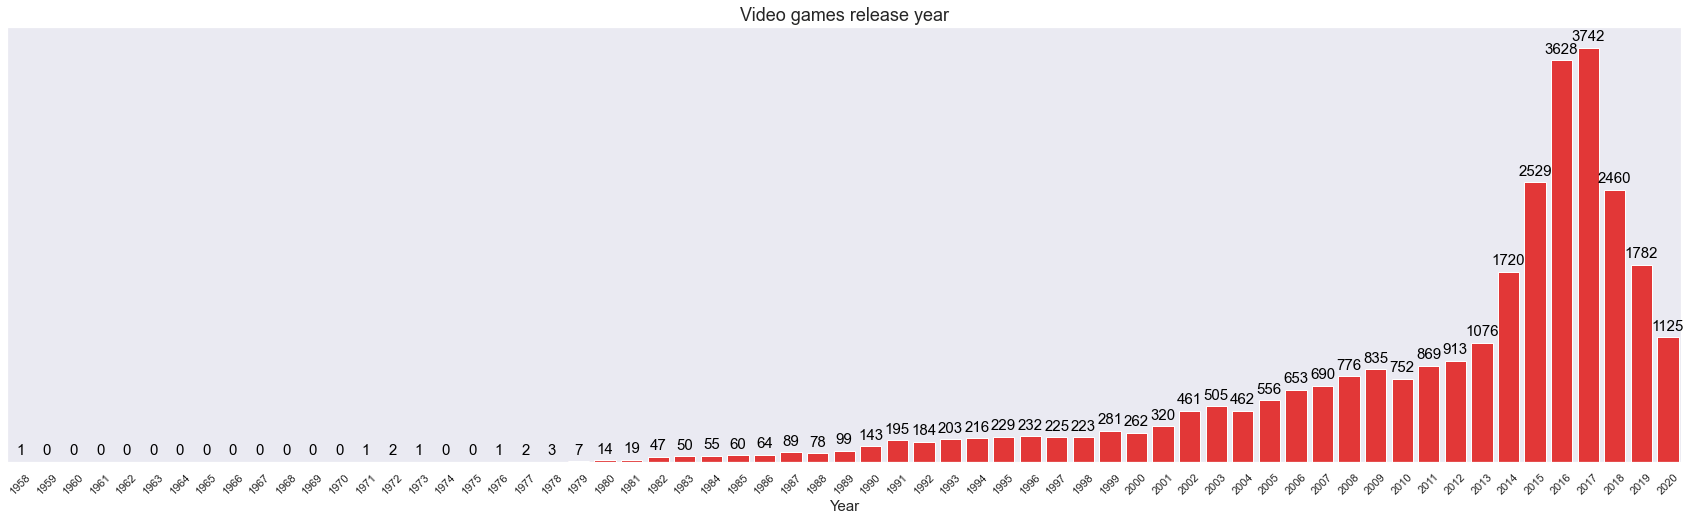

In [32]:
column = 'release_year'
title = 'Video games release year'
xlabel = 'Year'
ylabel = ''
plot_size = (30,8)
rotate_xticks = True
value_offset = 60
ordr = [i for i in range(int(unique_games.release_year.min()), 
                         int(unique_games.release_year.max()))
       ]
plotCount(unique_games, plot_size, column, title, xlabel, ylabel, color_games, 
          ordr, value_offset, rotate_xticks)

It is very clear that the number of video games has grown a lot year after year until it highest point in 2017. From there, the number of video games released has been decreasing but, compared to the years before 2015, it still high.

##### Release months

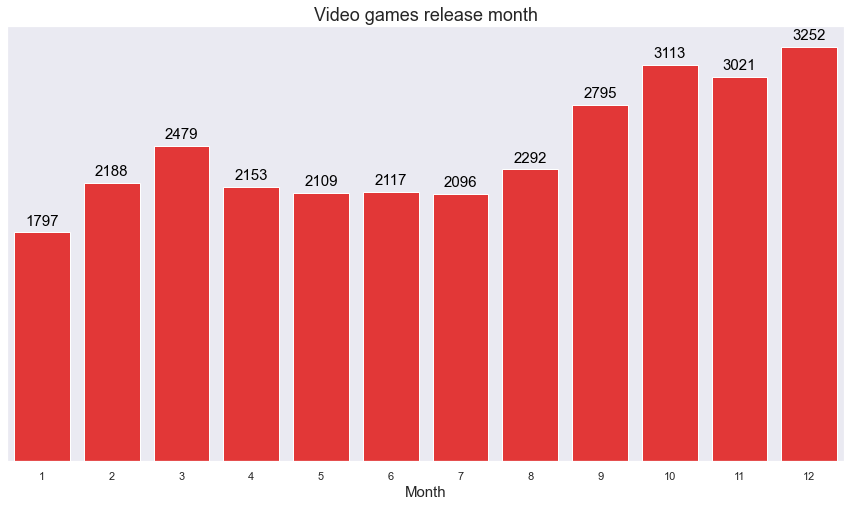

In [33]:
column = 'release_month'
title = 'Video games release month'
xlabel = 'Month'
ylabel = ''
plot_size = (15,8)
ordr = [i for i in range(1, 13)]
plotCount(unique_games, plot_size, column, title, xlabel, ylabel, color_games, 
          ordr, value_offset)

The number of video games by month is fairly uniform but we can see again some trends. It seems that from april to july the number of releases is "low" and we can see this number grows in the last three months. Then, there is a drastic decrease on january but the releases tend to raise until march.

##### Number of games by category

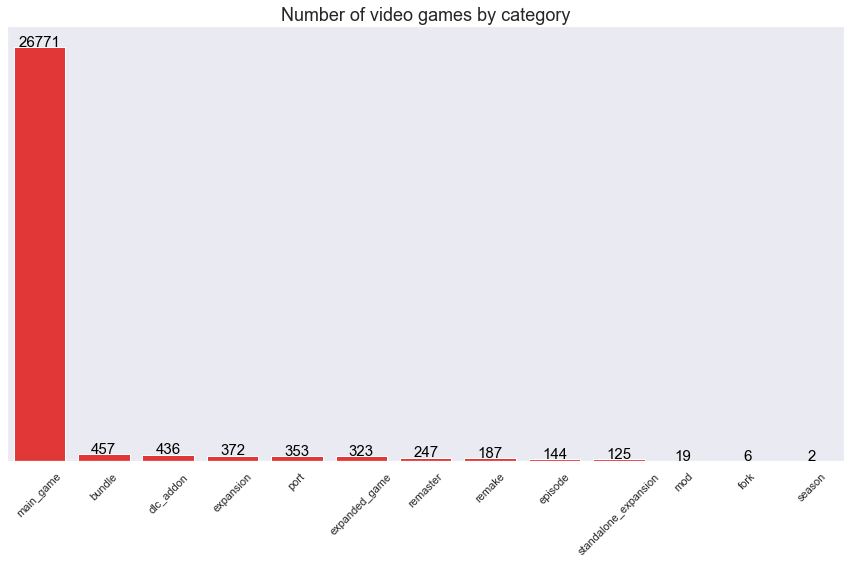

In [34]:
column = 'category'
title = 'Number of video games by category'
xlabel = ''
ylabel = ''
plot_size = (15,8)
ordr = unique_games[column].value_counts().index
rotate_labels = True
plotCount(unique_games, plot_size, column, title, xlabel, ylabel, color_games, 
          ordr, value_offset, rotate_labels)

We can see the data is practically composed of main games

##### Game modes count

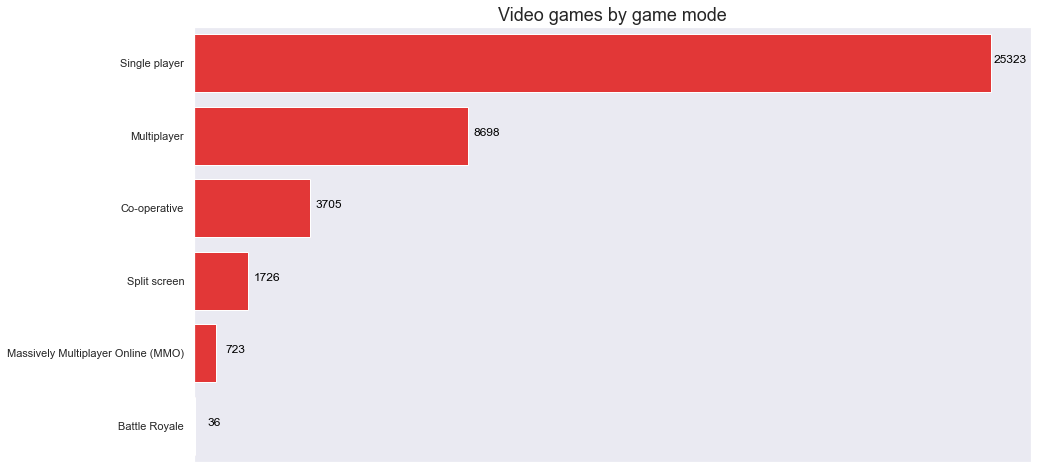

In [35]:
games_by_game_mode = games_df.groupby(
    ['name', 
     'game_modes'
    ]).size().groupby(
    'game_modes'
    ).size().to_frame().reset_index().sort_values(by=0,ascending=False)

barplot = sns.barplot(
    data=games_by_game_mode, 
    x=0,
    y='game_modes',
    color=color_games,
    orient = 'h',
)

barplot.set_title("Video games by game mode", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Se añade el valor de cada barra
for i in range(len(games_by_game_mode)):
    value = games_by_game_mode.iloc[i,1]
    barplot.text(value+600, i, int(value), color='black', ha="center")

By far, single player games is the most populated mode. That means the majority of games has this game mode and others.

##### Video games ratings distribution

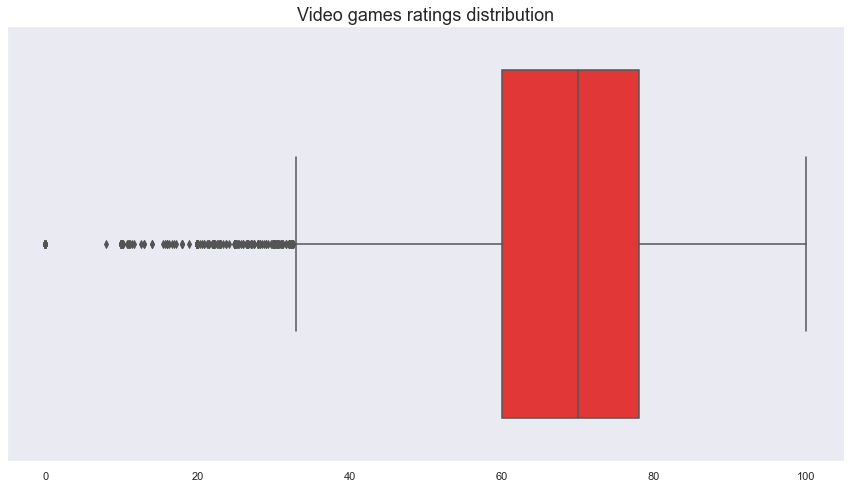

In [36]:
boxplot = sns.boxplot(
    x=unique_games.total_rating, 
    color=color_games)

boxplot.set_title('Video games ratings distribution', fontsize = 18)
_ = boxplot.set_xlabel('', fontsize = 15)

We can see there are many outliers, games as bad as they deserve ratings lower than 30!

### Conclusions

We have a lot of data! but most important, we have many interesting variables. With this datasets we can perform fairly deep analyis, not only about games reception, but also to study video games industry trends and its behavior. We can join this data to other resources to analyze video games sales; for example, which genre is the most profitable, target audiences, and so on. This information would be invaluable to investors and to video games studios themselves. 